# Gambling Analysis
Hannah Lee

### Goals
The purpose of this analysis gain insight on the players registered to an online casino.
We'll specifically be looking to be able to classify the players so that the casino will be able to identify their different classes of customers.

The two datasets were pulled from [The Cambridge Health Alliance](http://www.thetransparencyproject.org/Availabledataset.html) 
* Player Demographic Data
* Player Gambling Data

In [3]:
# Libraries
import numpy as np
import pandas as pd
import os as os
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.pyplot as plt

### Player Demographic Data

* UserID
* Country
* Language
* Gender
* Age
* fstpdate: Date of first game played

In [11]:
# Demographic data of players
demo = pd.read_csv('Gambling_Demographics.txt', sep='\t', header='infer')

demo.head()

,UserID,Country,Language,Gender,Age,fstpdate
0,1401233,Greece,Greek,Female,31,2/27/2005
1,1403738,France,French,Female,26,2/28/2005
2,1326398,Poland,Polish,Female,26,2/7/2005
3,1389454,Greece,Greek,Female,30,2/28/2005
4,1358966,Poland,Polish,Female,18,3/15/2005


#### Data investigation: Player Demographic Data

From our data investigation, we found that
* The age of the players was skewed towards the early-mid 20's
* A majority of the players are from Germany
* A majority of the players are Male


Text(0,0.5,'Frequency')

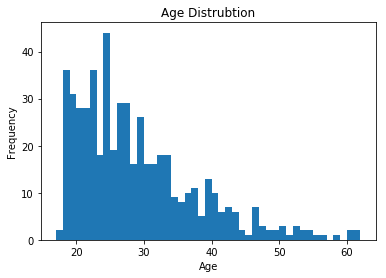

In [12]:
# Investigating player base
plt.hist(demo.Age, bins=np.arange(demo.Age.min(), demo.Age.max()+1)) 
plt.title("Age Distrubtion")
plt.xlabel("Age")
plt.ylabel("Frequency")

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 <a list of 21 Text xticklabel objects>)

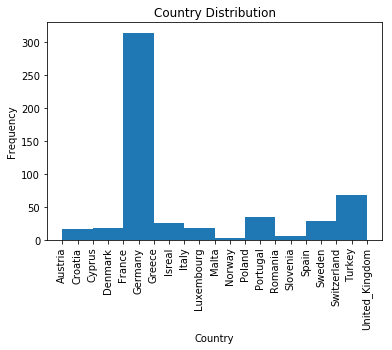

In [13]:
plt.hist(demo.Country)
plt.title("Country Distribution")
plt.xlabel("Country")
plt.ylabel("Frequency")
plt.xticks(rotation=90)

Text(0,0.5,'Frequency')

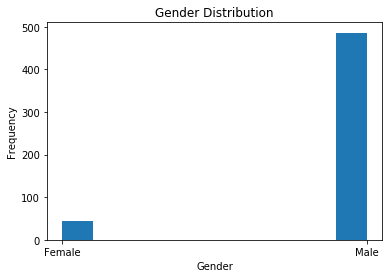

In [14]:
plt.hist(demo.Gender)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Frequency")

### Player Gambling Data

* UserID
* TimeDATE: Date played
* Stake: How much was bet
* Winnings: How much was won
* Bets: How many bets were placed

In [15]:
# Player Casino Winnings/Losings data
play = pd.read_csv('Gambling_DailyAggregation.txt', sep='\t', header='infer')

# Data Prep
play['OverallWin'] = play.Winnings-play.Stake

play['Date'] = pd.to_datetime(play.TimeDATE)

play['PlayMonth'] = pd.DatetimeIndex(play.Date).month
play['PlayWeekday'] = pd.DatetimeIndex(play.Date).weekday_name

play.head()

,UserID,TimeDATE,Stake,Winnings,Bets,OverallWin,Date,PlayMonth,PlayWeekday
0,1324368,3/31/2005,58.86,49.76,8,-9.10,2005-03-31,3,Thursday
1,1324368,4/1/2005,16.80,26.88,3,10.08,2005-04-01,4,Friday
2,1324368,4/2/2005,56.75,90.75,9,34.00,2005-04-02,4,Saturday
3,1324368,4/3/2005,47.00,17.00,4,-30.00,2005-04-03,4,Sunday
4,1324368,4/5/2005,12.00,0.00,3,-12.00,2005-04-05,4,Tuesday


#### Data investigation: Player Gambling Data

From our data investigation, we found that
* The player participation over time had severely decreased
* The player participation peaked around March 2005
* The overall winnings of early 2005 was highly volatile
* The overall winnings before March 2005 trended positive, but then trended extremely negative during March 2005

* People seemed to lose to most on Fridays

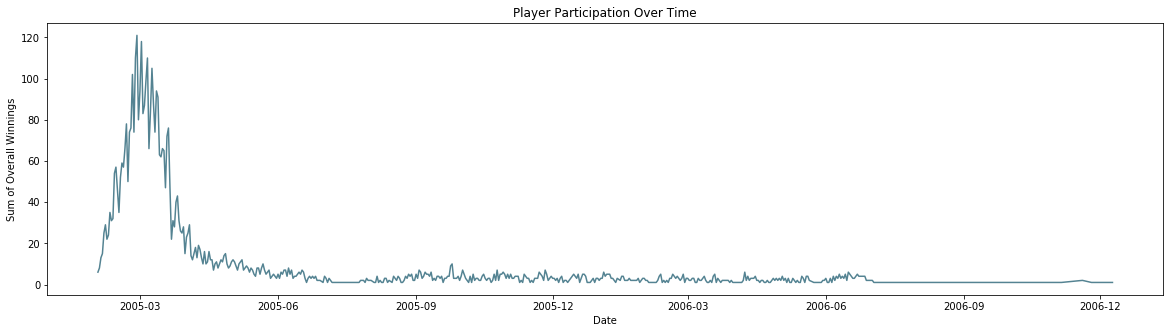

In [19]:
group_time = play.groupby('Date',as_index=False).agg({"OverallWin":"sum", "UserID":"count"})

plt.plot(group_time.Date, group_time.UserID, color='#548392')
plt.title("Player Participation Over Time")
plt.xlabel("Date")
plt.ylabel("Sum of Overall Winnings")
plt.rc('figure',figsize=(20,5))

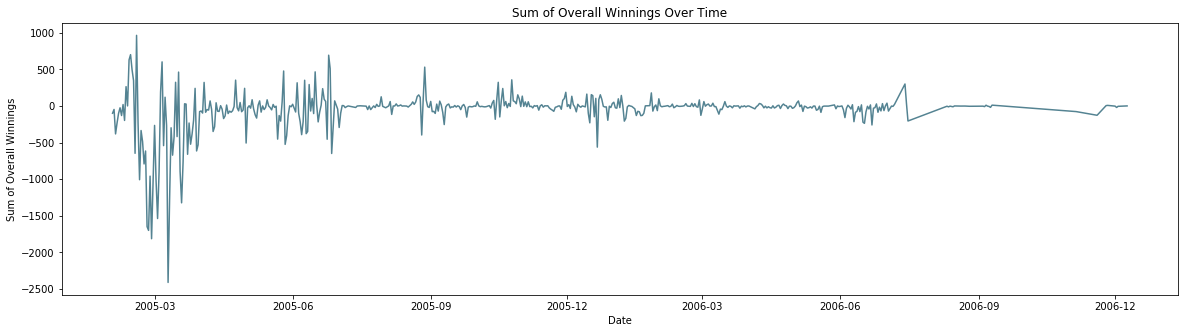

In [20]:
# Analyze overall winnings over time

plt.plot(group_time.Date, group_time.OverallWin, color='#548392')
plt.title("Sum of Overall Winnings Over Time")
plt.xlabel("Date")
plt.ylabel("Sum of Overall Winnings")
plt.locator_params


plt.rc('figure',figsize=(20,5))

Text(0,0.5,'Sum Overall Winnings')

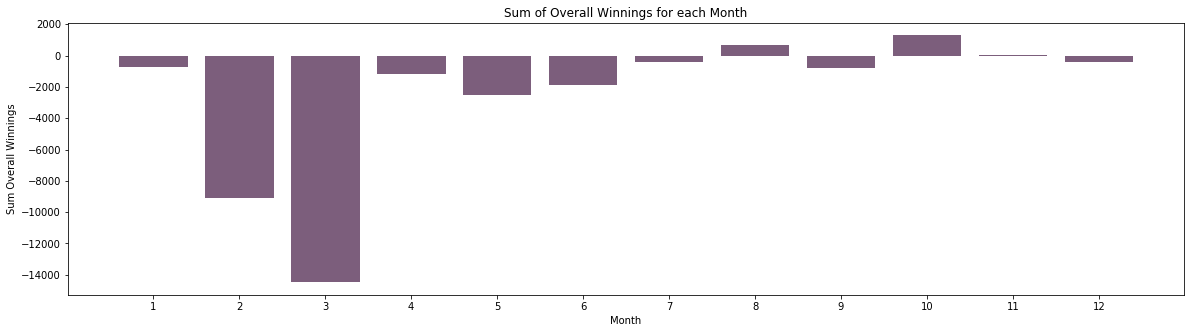

In [117]:
group_month = play.groupby('PlayMonth',as_index=False).agg({"OverallWin":"sum", "UserID":"count"})

plt.bar(group_month.PlayMonth, group_month.OverallWin, color='#7C5E7C')
plt.title("Sum of Overall Winnings for each Month")
plt.xlabel("Month")
plt.xticks(group_month.PlayMonth)
plt.ylabel("Sum Overall Winnings")

Text(0,0.5,'Sum Overall Winnings')

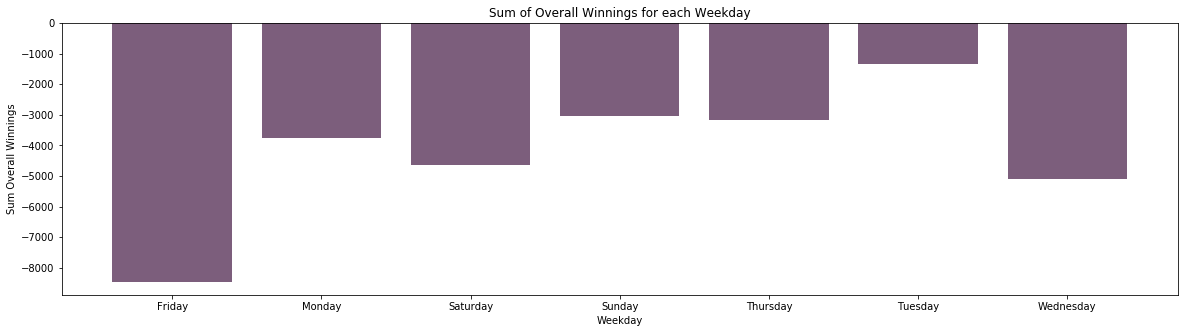

In [118]:
group_day = play.groupby('PlayWeekday',as_index=False).agg({"OverallWin":"sum", "UserID":"count"})

plt.bar(group_day.PlayWeekday, group_day.OverallWin, color ='#7C5E7C')
plt.title("Sum of Overall Winnings for each Weekday")
plt.xlabel("Weekday")
plt.ylabel("Sum Overall Winnings")

### Data Prep & Modeling (K-Means)

1. Group Gambling Data by UserID and find the average Stake, Winnings, Bets, and record count
2. Join the Gambling Data with the Demographic Data on the UserID key
3. Filter out all the non-numeric fields
4. Feature scale (standardize) the numeric fields
5. Apply k-means algorithm and join by index to the original joined dataset
6. Analyze the cluster profiles

In [26]:
# Group by User ID
grouped = play.groupby('UserID',as_index=False).agg({"Stake":"mean",
                             "Winnings":"mean",
                             "Bets": "mean",
                             "TimeDATE": "count"})

grouped = grouped.rename(columns={"Stake":"Avg_Stake",
                             "Winnings":"Avg_Winnings",
                             "Bets": "Avg_Bets",
                             "TimeDATE": "Play_Count"})

grouped.head()

,UserID,Avg_Stake,Avg_Winnings,Avg_Bets,Play_Count
0,1324368,90.278800,104.458000,6.160000,25
1,1324786,31.528462,24.907692,3.000000,13
2,1324808,5.920786,6.632714,4.285714,7
3,1324866,22.847222,25.884456,2.000000,9
4,1325158,47.975000,47.429167,7.083333,12


In [32]:
# Join Playing data with Demographic data

full= grouped.join(demo.set_index('UserID'), on='UserID')

full.head()

,UserID,Avg_Stake,Avg_Winnings,Avg_Bets,Play_Count,Country,Language,Gender,Age,fstpdate
0,1324368,90.278800,104.458000,6.160000,25,Portugal,Portuguese,Male,21,3/18/2005
1,1324786,31.528462,24.907692,3.000000,13,Austria,German,Male,19,8/6/2005
2,1324808,5.920786,6.632714,4.285714,7,Poland,Polish,Male,20,2/11/2005
3,1324866,22.847222,25.884456,2.000000,9,Poland,Polish,Male,38,2/3/2005
4,1325158,47.975000,47.429167,7.083333,12,Spain,Spanish,Male,26,2/1/2005


In [33]:
# Feature scale
scale_full = full.drop(['UserID','fstpdate','Gender','Country','Language'],1)
scale_full = pd.DataFrame( preprocessing.scale(scale_full))

# k means
km = KMeans(n_clusters=4,random_state=0)

km.fit(scale_full)
Cluster = pd.DataFrame(km.predict(scale_full))
Cluster = Cluster.rename(columns={0:"Cluster"})

full = full.join(Cluster)

full.head()

,UserID,Avg_Stake,Avg_Winnings,Avg_Bets,Play_Count,Country,Language,Gender,Age,fstpdate,Cluster
0,1324368,90.278800,104.458000,6.160000,25,Portugal,Portuguese,Male,21,3/18/2005,0
1,1324786,31.528462,24.907692,3.000000,13,Austria,German,Male,19,8/6/2005,1
2,1324808,5.920786,6.632714,4.285714,7,Poland,Polish,Male,20,2/11/2005,1
3,1324866,22.847222,25.884456,2.000000,9,Poland,Polish,Male,38,2/3/2005,3
4,1325158,47.975000,47.429167,7.083333,12,Spain,Spanish,Male,26,2/1/2005,1


### Cluster Profile Analysis: Summary

* There doesn't seem to be an interesting Country distrubition within each cluster

**Cluster 0**
* Medium stakes and winnings
* Places a high number of bets on average
* Plays frequently 
* Younger demographic (Mid 20's)

**Cluster 1**
* The most frequently classified cluster group
* Low stakes and winnings
* Places a low number of bets on average
* Doesn't play very frequently
* Younger demographic (Mid 20's)

**Cluster 2**
* The least frequently classified cluster group
* Extremely high stakes and winnings
* Places a large number of bets on average
* Plays frequently 
* Consists of all Males

**Cluster 3**
* Low stakes and winnings
* Places a low number of bets on average
* Older demographic (Early 40's)
* There seems to be proportionally higher female frequency in Cluster 3


In [35]:
full_grouped = full.groupby('Cluster',as_index=False).agg({"Avg_Stake":"mean",
                             "Avg_Winnings":"mean",
                             "Avg_Bets": "mean",
                             "Play_Count": "mean",
                             "Age": "mean",
                             "fstpdate":"count"})

full_grouped = full_grouped.rename(columns={"Play Count":"Play_Count Avg","Age":"Avg_Age", "fstpdate":"Count"})

full_grouped

,Cluster,Avg_Stake,Avg_Winnings,Avg_Bets,Play_Count,Avg_Age,Count
0,0,132.502710,123.224035,15.472981,16.990000,27.840000,100
1,1,26.709210,22.362199,4.268674,6.574675,24.103896,308
2,2,781.689266,775.835178,13.015218,19.153846,31.076923,13
3,3,34.928549,28.795161,4.682401,10.899083,40.834862,109


In [83]:
#Analyze Cluster Profiles individually

full['OverallWin']=full.Avg_Stake-full.Avg_Winnings

cl0 =full[full.Cluster==0]

cl1 =full[full.Cluster==1]

cl2 =full[full.Cluster==2]

cl3 =full[full.Cluster==3]

Text(0,0.5,'Frequency')

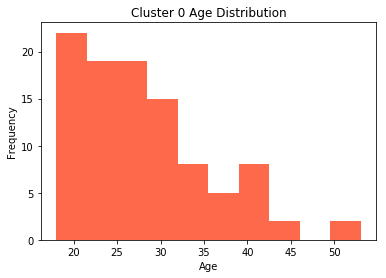

In [102]:
plt.hist(cl0.Age, color ='#FC6A4B')
plt.title("Cluster 0 Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")

Text(0,0.5,'Frequency')

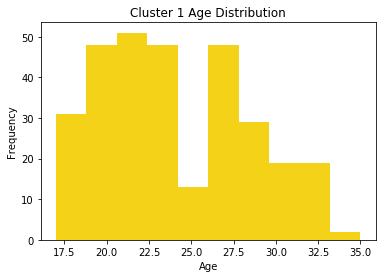

In [103]:
plt.hist(cl1.Age, color='#F3D218')
plt.title("Cluster 1 Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")

Text(0,0.5,'Frequency')

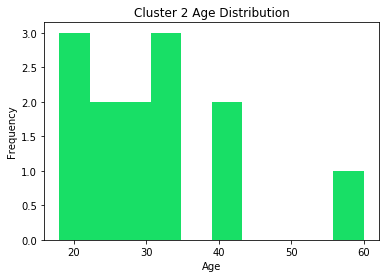

In [105]:
plt.hist(cl2.Age, color='#18DF66')
plt.title("Cluster 2 Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")

Text(0,0.5,'Frequency')

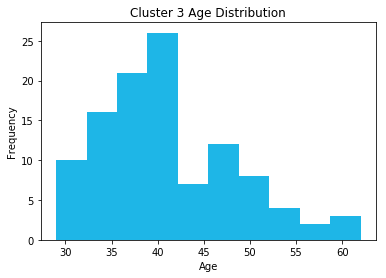

In [106]:
plt.hist(cl3.Age, color='#1EB6E7')
plt.title("Cluster 3 Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")

Text(0,0.5,'Frequency')

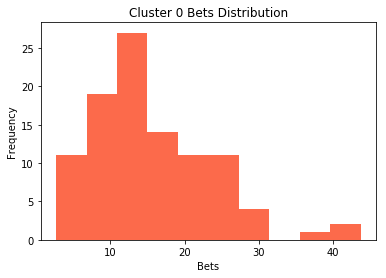

In [109]:
plt.hist(cl0.Avg_Bets, color ='#FC6A4B')
plt.title("Cluster 0 Bets Distribution")
plt.xlabel("Bets")
plt.ylabel("Frequency")

Text(0,0.5,'Frequency')

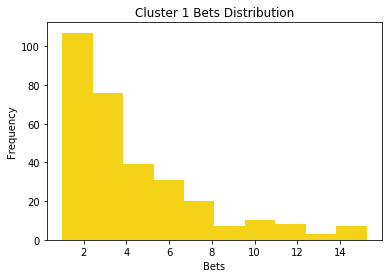

In [111]:
plt.hist(cl1.Avg_Bets, color='#F3D218')
plt.title("Cluster 1 Bets Distribution")
plt.xlabel("Bets")
plt.ylabel("Frequency")

Text(0,0.5,'Frequency')

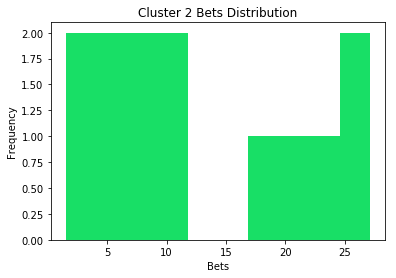

In [113]:
plt.hist(cl2.Avg_Bets, color='#18DF66')
plt.title("Cluster 2 Bets Distribution")
plt.xlabel("Bets")
plt.ylabel("Frequency")

Text(0,0.5,'Frequency')

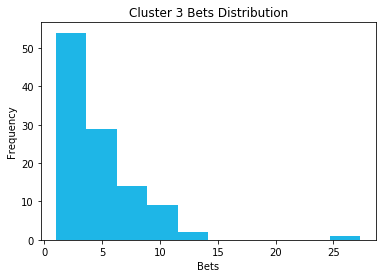

In [107]:
plt.hist(cl3.Avg_Bets,color='#1EB6E7')
plt.title("Cluster 3 Bets Distribution")
plt.xlabel("Bets")
plt.ylabel("Frequency")

([0, 1], <a list of 2 Text xticklabel objects>)

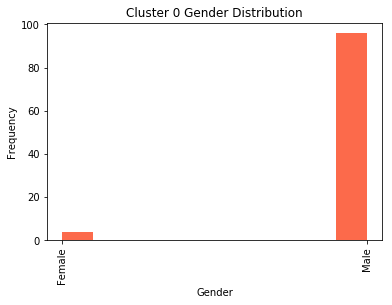

In [110]:
plt.hist(cl0.Gender, color ='#FC6A4B')
plt.title("Cluster 0 Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.xticks(rotation=90)

([0, 1], <a list of 2 Text xticklabel objects>)

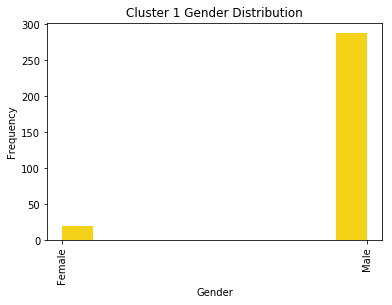

In [112]:
plt.hist(cl1.Gender, color='#F3D218')
plt.title("Cluster 1 Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.xticks(rotation=90)

([0], <a list of 1 Text xticklabel objects>)

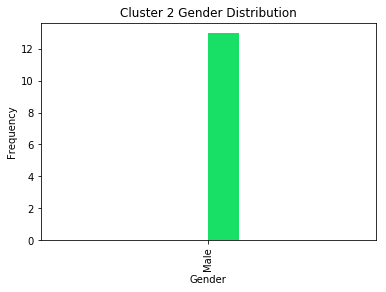

In [114]:
plt.hist(cl2.Gender, color='#18DF66')
plt.title("Cluster 2 Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.xticks(rotation=90)

([0, 1], <a list of 2 Text xticklabel objects>)

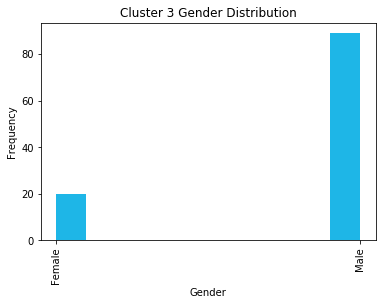

In [108]:
plt.hist(cl3.Gender, color='#1EB6E7')
plt.title("Cluster 3 Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.xticks(rotation=90)